In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import src.data.ToyData as ToyData
import src.NeuralOp.neural_operator as neural_operator
import src.NeuralOp.blocks as blocks
import src.Trainer as Trainer
import src.SDESolver as SDESolver
import src.SDE as SDE
from src.plot import plot_trajectory_2d, plot_matrix, plot_score_field
import matplotlib.pyplot as plt
import random 
import experiments.ssm_config as ssm_config
import pandas as pd
import hyperiax
from hyperiax.tree.topology import read_topology
from hyperiax.tree import HypTree
from src.data.ButterflyData import ButterflyDataGenerator


def get_random_int():
    return random.randint(0, 1000000)

In [2]:


landmarks = pd.read_csv("./data/butterflies/papilio_shapes.csv", sep=",", header = 0)

landmarks.head()

,node_names,edges,0,1,2,3,4,5,6,7,...,226,227,228,229,230,231,232,233,234,235
0,xx_0,13.435098,24.127419,45.308372,40.163723,69.381874,54.300377,96.251465,67.085780,124.642525,...,-78.030876,153.39763,-66.951400,123.901794,-54.439163,95.424270,-39.931390,67.915820,-23.825785,44.944836
1,xx_1,23.277729,23.127708,50.703790,39.201443,74.751335,53.041813,101.683945,64.999870,129.932080,...,-76.894030,157.04372,-65.354890,127.778410,-53.199620,99.557160,-39.102290,72.174400,-22.898556,49.741154
2,xx_2,31.773878,25.207127,37.467770,41.664463,62.065840,56.332710,88.628440,69.693730,117.852950,...,-79.649050,148.05229,-68.822860,118.855890,-56.493690,89.475044,-41.138920,62.359253,-24.945760,38.032090
3,Papilio_gigon,55.361300,23.735891,58.050270,37.984425,81.869570,50.863472,109.181175,62.963516,136.211240,...,-74.574860,158.87724,-63.714386,130.391700,-50.873894,102.843530,-38.005547,76.238174,-22.763357,54.666590
4,xx_3,27.830029,22.953447,47.230633,39.802616,70.985880,54.082817,98.127780,66.117360,126.809710,...,-77.890910,156.26543,-66.344536,126.476480,-54.238580,97.945114,-39.731285,70.132614,-23.114927,47.402580


In [3]:
# extract the butterfly with nodename without xx beginning
def extract_leaf_butterfly_landmarks(landmarks):
    for node_name in landmarks['node_names']:
        if node_name.startswith('xx'):
            landmarks = landmarks[landmarks['node_names'] != node_name]
    return landmarks

leaf_butterfly_landmarks = extract_leaf_butterfly_landmarks(landmarks)

#print all rows of leaf_butterfly_landmarks
print(leaf_butterfly_landmarks)

             node_names     edges          0          1          2          3  \
3         Papilio_gigon  55.36130  23.735891  58.050270  37.984425  81.869570   
8     Papilio_deiphobus  42.66970  24.224997  57.527710  39.766480  82.669380   
11       Papilio_xuthus  13.00060  27.888336  27.037397  45.394100  50.903904   
12     Papilio_zelicaon  13.00060  30.259157  50.448006  50.826874  71.077705   
13  Papilio_cresphontes  34.79410  23.190031  28.261755  42.796665  54.072983   
18      Papilio_troilus  22.98890  22.939156  21.261497  38.788055  51.689873   
20  Papilio_aristodemus  11.32880  21.962465  43.201744  45.933720  64.246120   
21      Papilio_glaucus  12.98390  26.736094  20.725727  44.880700  49.584710   
22       Papilio_memnon  12.98390  23.397232  55.301500  35.457573  78.682400   
24    Papilio_polyxenes  10.00160  28.528736  34.369843  47.152237  58.863632   
26        Papilio_thoas  20.91900  22.930030  35.049280  41.416900  63.080696   
27       Papilio_ambrax   6.

(17, 236)
(17, 118, 2)


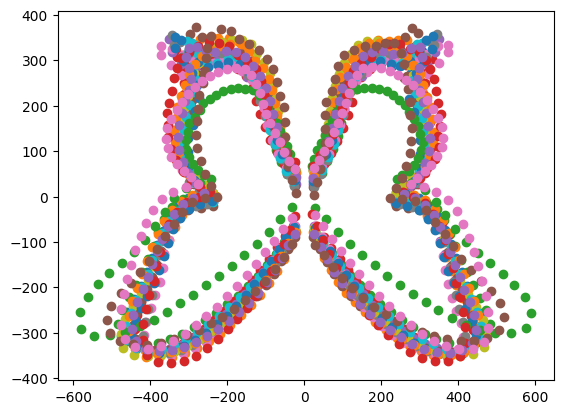

In [4]:
# extract the xs and ys from leaf_butterfly_landmarks
#landmarks are start from the 3rd column, along with the node_names
landmarks = leaf_butterfly_landmarks.iloc[:, 2:]
xs = landmarks.iloc[:, 0::2]
ys = landmarks.iloc[:, 1::2]
landmarks = landmarks.to_numpy()
print(landmarks.shape)
# reshape the butterfly_data to 2D array (butterfly_data.shape[0], xs.shape[1], 2)
butterfly_data = landmarks.reshape(xs.shape[0], xs.shape[1], 2)
print(butterfly_data.shape)


for i in range(butterfly_data.shape[0]):
    plt.scatter(butterfly_data[i, :, 0], butterfly_data[i, :, 1])






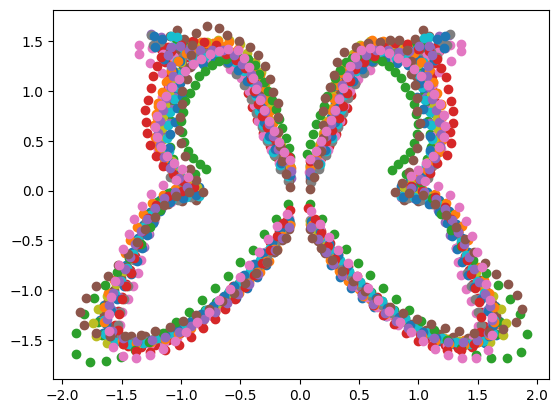

In [5]:
# normalize the butterfly_data for each butterfly
for i in range(butterfly_data.shape[0]):
    butterfly_data[i, :, 0] = (butterfly_data[i, :, 0] - jnp.mean(butterfly_data[i, :, 0])) / jnp.std(butterfly_data[i, :, 0])
    butterfly_data[i, :, 1] = (butterfly_data[i, :, 1] - jnp.mean(butterfly_data[i, :, 1])) / jnp.std(butterfly_data[i, :, 1])


# plot the butterfly_data
for i in range(butterfly_data.shape[0]):
    plt.scatter(butterfly_data[i, :, 0], butterfly_data[i, :, 1])
plt.show()


(32, 118, 2)


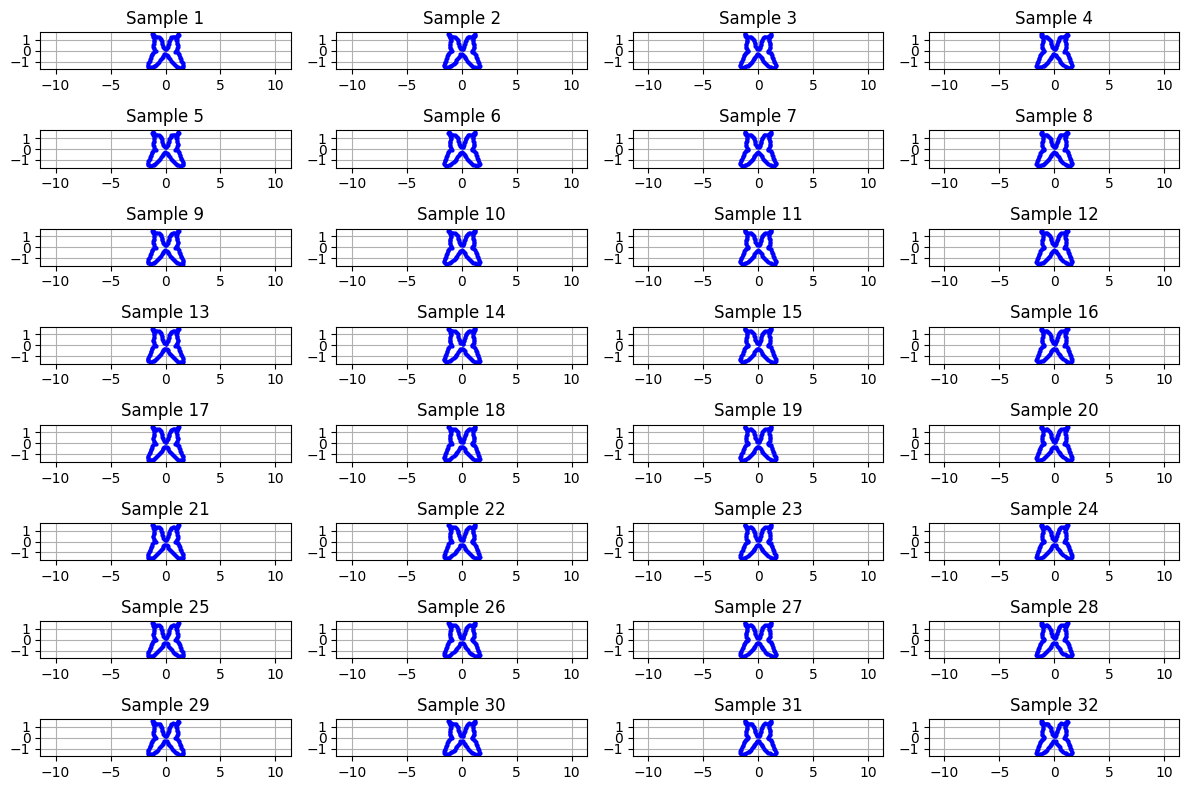

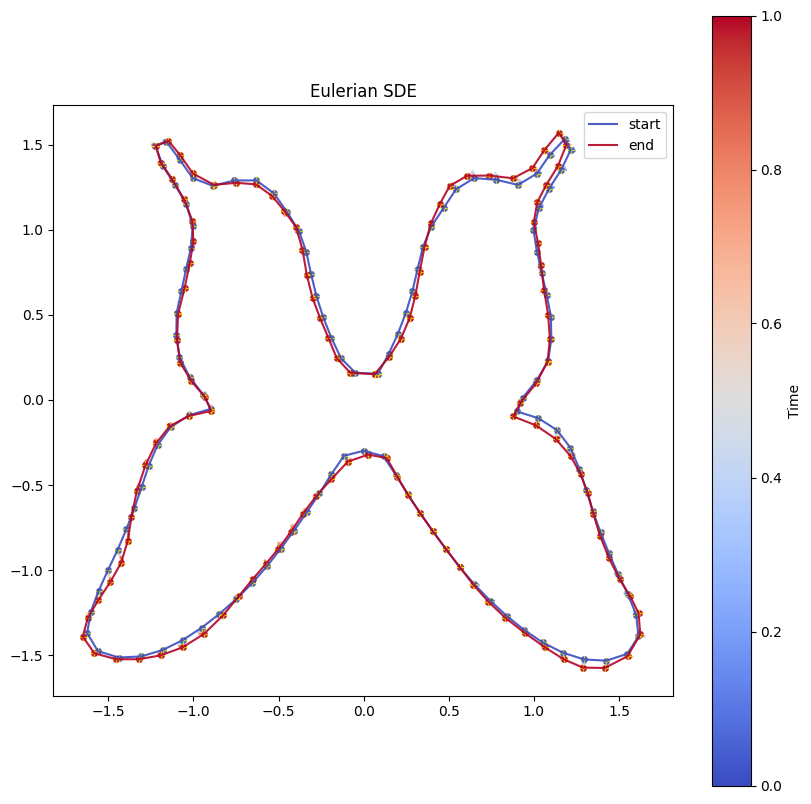

(101, 118, 2)


Training neural operator:   0%|          | 0/6000 [00:00<?, ?it/s]

(100, 16)


Training loss: 218.79095458984375: 100%|██████████| 6000/6000 [08:06<00:00, 12.33it/s]


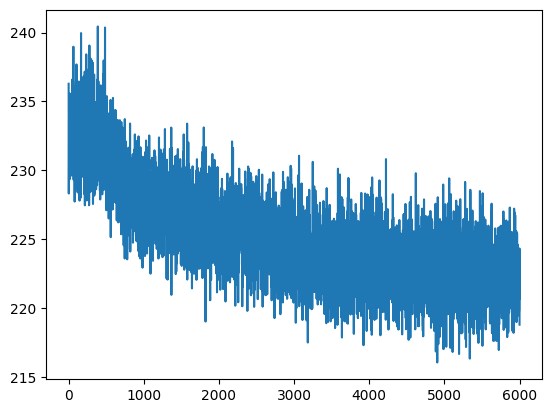

In [6]:
# butterfly data generator
butterfly_data_generator = ButterflyDataGenerator(butterfly_data[10], seed=get_random_int())
test_data = butterfly_data_generator.generate_data(num_landmarks = 118, batch_size=32)
print(test_data.shape)
butterfly_data_generator.visualize_samples(test_data)
#eulerian sde
sde_butterfly = SDE.Kunita_Eulerian_SDE(sigma=0.6, kappa=0.2, grid_dim=2, grid_num=32, grid_range=[-2, 2], x0=test_data[0])
# sde_butterfly = SDE.Kunita_Lagrange_SDE(sigma=4.0, kappa=0.5, x0=test_data[0])
solver_butterfly = SDESolver.EulerMaruyama.from_sde(sde_butterfly, 0.01, 1, 2)
xs_butterfly, _ = solver_butterfly.solve(test_data[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_butterfly, "Eulerian SDE", simplified=False)
plt.show()
print(xs_butterfly.shape)

model = neural_operator.CTUNO1D(out_co_dim=2, lifting_dim=8, co_dims_fmults=(1, 2, 4, 4), n_modes_per_layer=(16, 8, 6, 6), norm="instance", act="leaky_relu")

trainer = Trainer.NeuralOpTrainer(seed=get_random_int(), landmark_num=118)

train_state_butterfly = trainer.train_state_init(model, lr=5e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), butterfly_data[0].shape), 't': jnp.array([0]), 'x0': butterfly_data[0], 'object_fn': 'Heng'})
train_state_butterfly, losses_butterfly = trainer.train(train_state_butterfly, sde_butterfly, solver_butterfly, butterfly_data_generator, 6000, batch_size=16)
plt.plot(losses_butterfly)
plt.show()


(1, 1024, 2)


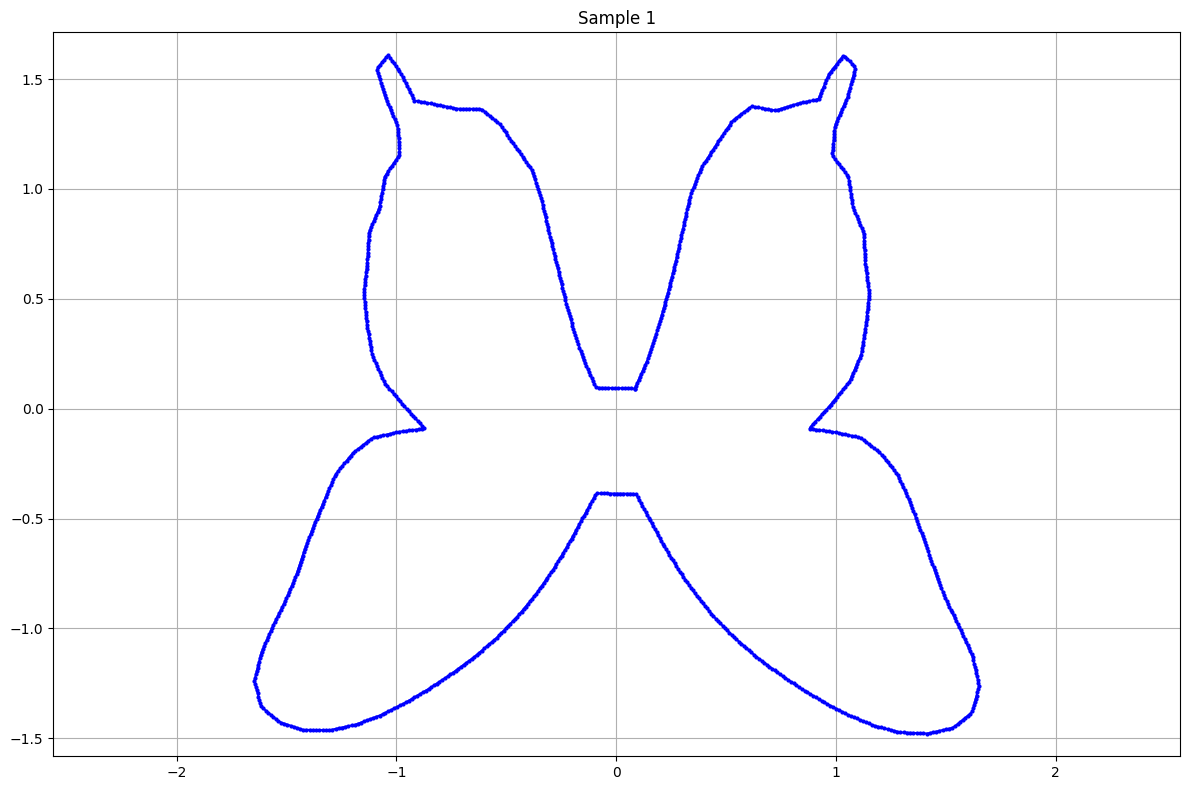

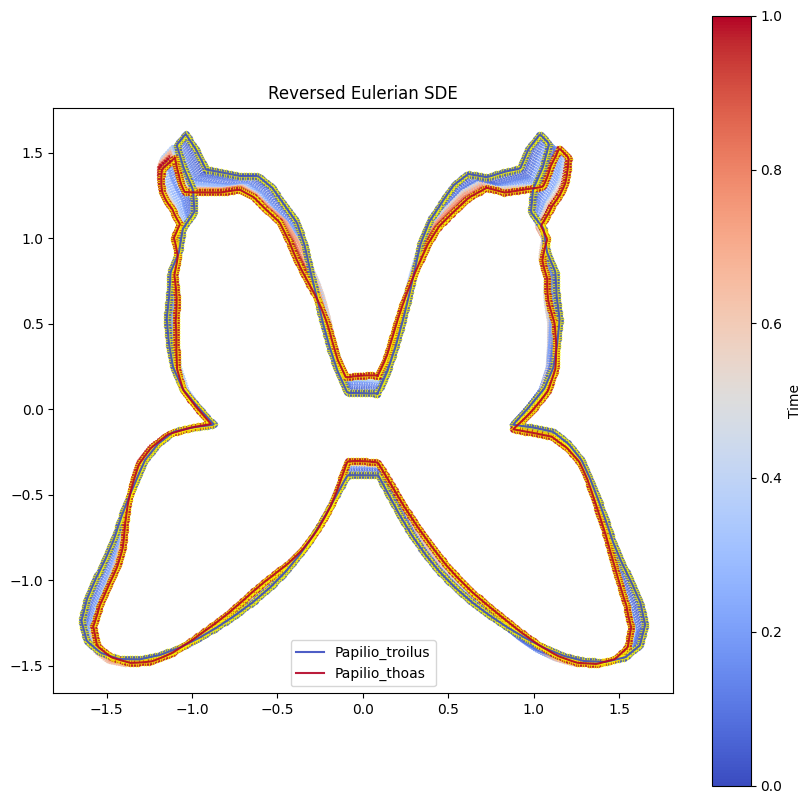

In [18]:
from src.plot import plot_trajectory_2d

score_fn_butterfly = lambda x, t, x0: train_state_butterfly.apply_fn(train_state_butterfly.params, x, t)
X_T_data_generator = ButterflyDataGenerator(butterfly_data[5], seed=get_random_int())
X_T_data = X_T_data_generator.generate_data(1024, batch_size=1)
print(X_T_data.shape)
X_T_data_generator.visualize_samples(X_T_data)

reversed_sde_butterfly = SDE.Time_Reversed_SDE(sde_butterfly, score_fn_butterfly, 1, 0.01)
reversed_solver_butterfly = SDESolver.EulerMaruyama.from_sde(reversed_sde_butterfly, 0.01, 1, 2, condition_x=test_data[0])
xs_butterfly, _ = reversed_solver_butterfly.solve(X_T_data[0], jrandom.PRNGKey(get_random_int()))
name_x0 = leaf_butterfly_landmarks.iloc[10, 0]
name_xT = leaf_butterfly_landmarks.iloc[5, 0]

plot_trajectory_2d(xs_butterfly, "Reversed Eulerian SDE", trajectory_alpha=0.9, start_shape_name=name_xT, end_shape_name=name_x0, simplified=False)

Papilio_thoas
Papilio_troilus


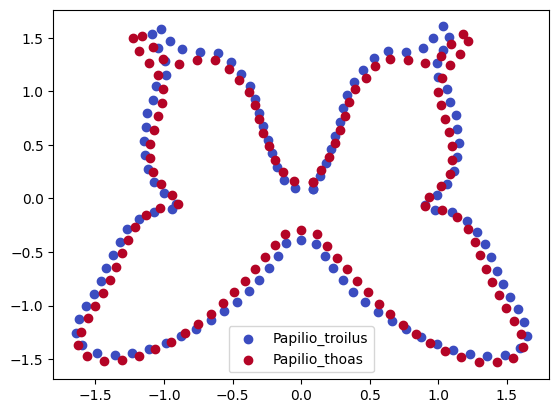

In [15]:
name_x0 = leaf_butterfly_landmarks.iloc[10, 0]
name_xT = leaf_butterfly_landmarks.iloc[5, 0]
print(name_x0)
print(name_xT)

X_0 = butterfly_data_generator.generate_data(118, batch_size=1)
X_T = X_T_data_generator.generate_data(118, batch_size=1)

# plot the two butterflys on the same plot with different colors and different markers, with labels
plt.scatter(X_T[0, :, 0], X_T[0, :, 1], color=plt.cm.coolwarm(0), label=name_xT)
plt.scatter(X_0[0, :, 0], X_0[0, :, 1], color=plt.cm.coolwarm(255), label=name_x0)

plt.legend()
plt.show()

